# **Convolutional Neural Networks for Facial Expression Recognition**
## Seminar II
### Erik Greblo


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub


path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")
print("Path to dataset files:", path)




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\eriki\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\eriki\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\eriki\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\Users\eriki\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "c:\Users\eriki\anaconda3\lib\site-pack

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

In [4]:
import torch
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

False


In [3]:
# Import the necessary libraries
from PIL import Image
from numpy import asarray

img = Image.open(path + '/images/train/angry/0.jpg')

numpydata = asarray(img)
print(type(numpydata))
print(numpydata.shape)


<class 'numpy.ndarray'>
(48, 48)


In [4]:
import glob
train_images = []
train_indexes = []
val_images = []
val_indexes = []
emotion_indexes = {"angry" : 0,
                   "disgust" : 1,
                   "fear" : 2,
                   "happy" : 3,
                   "sad" : 4,
                   "surprise" : 5,
                   "neutral" : 6
                   }
for f in glob.iglob(path + '/images/train/*'):
  emotion = f.split('train\\')[1]
  print(emotion)
  for f in glob.iglob(f + '/*'):
      img = Image.open(f).convert('L')  # 'L' za grayscale, ako je to slučaj
      img_array = np.asarray(img, dtype=np.float32) / 255.0  # normalizacija u [0,1]

      train_images.append(img_array)
      train_indexes.append(emotion_indexes[emotion])

x_train = np.array(train_images)
y_train = train_indexes
for f in glob.iglob(path + '/images/validation/*'):
  emotion = f.split('validation\\')[1]
  print(emotion)
  for f in glob.iglob(f + '/*'):
      img = Image.open(f).convert('L')  # 'L' za grayscale, ako je to slučaj
      img_array = np.asarray(img, dtype=np.float32) / 255.0  # normalizacija u [0,1]

      val_images.append(img_array)
      val_indexes.append(emotion_indexes[emotion])

x_val = np.array(val_images)
y_val = val_indexes

angry
disgust
fear
happy
neutral
sad
surprise
angry
disgust
fear
happy
neutral
sad
surprise


In [5]:
print(len(x_train),len(y_train))
print(x_train[0].shape)
print(x_train[0],y_train[0])
print(len(x_val),len(y_val))

x_val_split, x_test, y_val_split, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(x_val_split)), torch.from_numpy(np.array(y_val_split)))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(x_test)), torch.from_numpy(np.array(y_test)))
len(val_dataset)
len(test_dataset)


28821 28821
(48, 48)
[[0.28235295 0.30588236 0.31764707 ... 0.20392157 0.16862746 0.15686275]
 [0.25490198 0.24313726 0.23137255 ... 0.21568628 0.20392157 0.1764706 ]
 [0.18431373 0.16470589 0.23529412 ... 0.18431373 0.21176471 0.19215687]
 ...
 [0.35686275 0.25490198 0.18039216 ... 0.2901961  0.21176471 0.16862746]
 [0.29803923 0.3137255  0.29803923 ... 0.42352942 0.27058825 0.18039216]
 [0.3019608  0.2901961  0.31764707 ... 0.4117647  0.42352942 0.32156864]] 0
7066 7066


3533

disgust: 547 samples


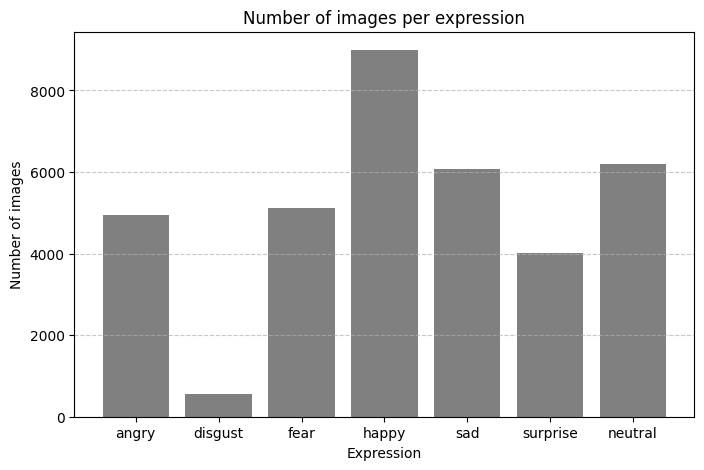

In [83]:
index_to_emotion = {v: k for k, v in emotion_indexes.items()}
counts = np.bincount(np.concatenate([y_train, y_val]), minlength=len(emotion_indexes))
emotion_names = [index_to_emotion[i] for i in range(len(counts))]

print(f"{index_to_emotion[1]}: {counts[1]} samples")
# Crtanje histograma
plt.figure(figsize=(8, 5))
plt.bar(emotion_names, counts, color='gray')
plt.xlabel("Expression")
plt.ylabel("Number of images")
plt.title("Number of images per expression")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

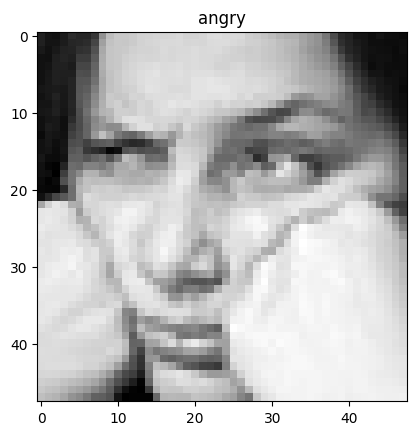

In [22]:
def emotion_index_to_string(index):
    return index_to_emotion[index]
def show_image(x, y,index):
  img = x[index]
  y_true = y[index]
  plt.imshow(img, interpolation='nearest', cmap='gray')
  plt.title(emotion_index_to_string(y_true))
  plt.show()

index = 10
show_image(x_train,y_train ,index)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision

class SimpleLinearModel(nn.Module):
    def __init__(self, input_dim = (48,48), no_classes = 7):
        super(SimpleLinearModel, self).__init__()
        self.linear1 = nn.Linear(input_dim[0] * input_dim[1], no_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear1(x.to(torch.float))
        return x



In [10]:
import time
def train(model, x_data, y_data, epochs=1, batch_size = 128,lr=1e-3, weight_decay=1e-3, get_losses=False):
    start_time = time.time()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    model.train()

    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(x_data)), torch.from_numpy(np.array(y_data)))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    print("Starting training...")
    losses = []
    val_losses = []

    for i in range(epochs):
        model.train()
        if i % 10 == 0:
            print(f"\tEpoch[{i+1}/{epochs}]")
        epoch_loss_sum = 0
        for batch in train_loader:
            X,y_true = batch
            X = X.to(device)
            y_true = y_true.to(device)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y_true.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss_sum += loss.item()
        epoch_loss = epoch_loss_sum / len(train_loader)
        losses.append(epoch_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                val_pred = model(X_val)
                loss = F.cross_entropy(val_pred, y_val.long())
                val_loss += loss.item() * X_val.size(0)

        avg_val_loss = val_loss / len(val_dataset)
        val_losses.append(avg_val_loss)

    print("Training lasted %s seconds." % (time.time() - start_time))
    if get_losses:
        return losses, val_losses

def eval(model, x_test, y_test, batch_size = 128):

    print("Starting evaluation...")
    model.eval()

    with torch.no_grad():

        test_losses = []
        correct = 0
        count = 0

        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        for batch in test_loader:
            X, y_true = batch
            X = X.to(device)
            y_true = y_true.to(device)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y_true.long())
            test_losses.append(loss)
            count += len(y_true)
            correct += (y_pred.argmax(dim=-1) == y_true).float().sum()

        eval_loss = sum(test_losses) / len(test_losses)
        eval_acc = correct / count

    print(f"Model accuracy = {eval_acc.item()*100:.2f}%\nModel error = {eval_loss.item():.2f}")
    return eval_loss.item(), eval_acc.item()


In [11]:
# Sanity check
def sanity_check(model, x_train, y_train):
  model.eval()  # evaluacijski mod (ne treniramo ga)

  with torch.no_grad():  # nema gradijenata
      x_tensor = torch.from_numpy(x_train).to(device)
      y_tensor = torch.from_numpy(np.asarray(y_train)).long().to(device)

      y_pred = model(x_tensor)
      initial_loss = F.cross_entropy(y_pred, y_tensor)

  print(f"Initial Loss without regularization: {initial_loss.item():.4f}")
model = SimpleLinearModel()
model.to(device)
sanity_check(model, x_train, y_train)

Initial Loss without regularization: 1.9299


In [12]:
model_linear = SimpleLinearModel()
model_linear.to(device)
model_linear_losses, model_linear_val_losses = train(model_linear, x_train, y_train, epochs=70, get_losses=True)
err, acc = eval(model_linear, x_test, y_test)
show_losses(model_linear_losses, model_linear_val_losses)

Starting training...
	Epoch[1/70]
	Epoch[11/70]
	Epoch[21/70]
	Epoch[31/70]
	Epoch[41/70]
	Epoch[51/70]
	Epoch[61/70]
Training lasted 28.562337160110474 seconds.
Starting evaluation...
Model accuracy = 37.53%
Model error = 1.63


NameError: name 'show_losses' is not defined

In [ ]:
torch.save(model.state_dict(), f"model_simple_weights_{acc*100:.0f}acc.pth")

In [ ]:
model = SimpleLinearModel()
model.to(device)
model.load_state_dict(torch.load("model_simple_weights_31acc.pth"))
err, acc = eval(model, x_test, y_test)

Starting evaluation...
Model accuracy = 30.81%
Model error = 37.54


In [ ]:
class SimplerCNN(nn.Module):
    def __init__(self, img_dims=(48, 48), num_classes=7):
        super(SimplerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1, padding='same')
        self.fc = nn.Linear(16 * (img_dims[0] // 2) * (img_dims[1] // 2), num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x.to(torch.float)))
        x = F.max_pool2d(x, 2, 2)
        x = torch.flatten(x, start_dim=-3)
        x = self.fc(x)
        return F.softmax(x,dim=1)

(28821, 48, 48)
Starting training...
	Epoch[1/50]
	Epoch[11/50]
	Epoch[21/50]
	Epoch[31/50]
	Epoch[41/50]
Training lasted 39.42159819602966 seconds.
Starting evaluation...
Model accuracy = 37.45%
Model error = 1.78


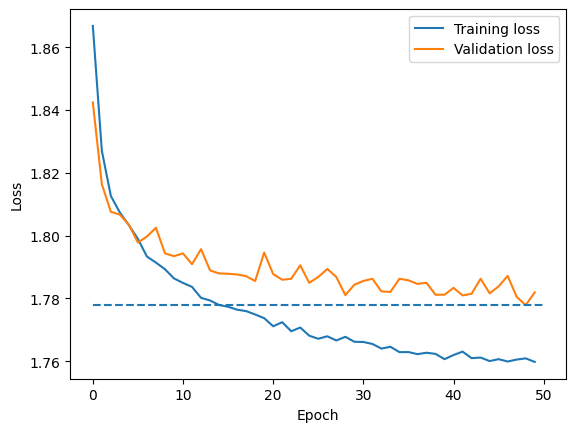

In [ ]:
model_cnn = SimplerCNN()
model_cnn.to(device)
print(x_train.shape)
model_simple_cnn_losses, model_simple_cnn_val_losses = train(model_cnn, x_train, y_train, epochs=50, get_losses=True)
err, acc = eval(model_cnn, x_test, y_test)
show_losses(model_simple_cnn_losses, model_simple_cnn_val_losses)

In [ ]:
torch.save(model_cnn.state_dict(), f"model_simple_cnn_weights_{acc*100:.0f}acc.pth")

In [ ]:
import random
def show_random_predictions(model,images,labels,no_rows_cols = 3):

    fig, ax = plt.subplots(no_rows_cols, no_rows_cols)
    fig.tight_layout()

    for i in range(no_rows_cols):
        for j in range(no_rows_cols):

            index = random.randint(0,len(images) - 1)
            y_true = labels[index]
            img = images[index]
            input_tensor = torch.from_numpy(img).unsqueeze(0).to(device)   # -> (1, 1, 48, 48)
            y_pred = model(input_tensor).argmax(dim=-1).item()
            color = 'k' if y_pred == y_true else 'r'
            print(f"y_pred = {y_pred}, y_true={y_true}")
            ax[i,j].imshow(img, cmap='gray')
            ax[i,j].set_title(f"T = {emotion_index_to_string(y_true)} | P = {emotion_index_to_string(y_pred)}", fontdict={'color': color})

show_random_predictions(model_cnn,x_test,y_test)

NameError: name 'model_cnn' is not defined

In [ ]:
def show_losses(losses, val_losses=[]):
  plt.plot(losses)
  plt.plot(val_losses)
  plt.hlines(y=min(val_losses), xmin=0, xmax=len(losses), linestyles='dashed')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(["Training loss", "Validation loss"])
  plt.show()


In [ ]:
def show_multiple_losses(all_losses, all_val_losses=None, labels=None):
    if all_val_losses is None:
        all_val_losses = [[] for _ in range(len(all_losses))]

    if labels is None:
        labels = [f"Model {i+1}" for i in range(len(all_losses))]

    plt.figure(figsize=(10, 6))

    for i in range(len(all_losses)):
        train_loss = all_losses[i]
        val_loss = all_val_losses[i] if i < len(all_val_losses) else []

        # Plot training loss
        plt.plot(train_loss, label=f"{labels[i]} - Train")

        # Plot validation loss if provided
        if val_loss:
            plt.plot(val_loss, label=f"{labels[i]} - Val")
            plt.hlines(y=min(val_loss), xmin=0, xmax=len(train_loss), linestyles='dashed', colors='gray', alpha=0.3)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
class StandardCNN(nn.Module):
    def __init__(self, img_dims=(48, 48), num_classes=7, M=2, N=2,
                 conv_channels=[16, 32], fc_dims=[256, 128], krenel_sizes=[3,3],dropout_p=0.5):
        super(StandardCNN, self).__init__()

        self.convs = nn.ModuleList()
        self.bns_conv = nn.ModuleList()
        self.dropouts_conv = nn.ModuleList()

        in_channels = 1  # Grayscale input

        # [Conv - S - ReLU - Dropout - MaxPool] × M
        for i in range(M):
            out_channels = conv_channels[i]
            krenel_size = krenel_sizes[i]
            self.convs.append(nn.Conv2d(in_channels, out_channels, kernel_size=krenel_size, padding=1))
            self.bns_conv.append(nn.BatchNorm2d(out_channels))
            self.dropouts_conv.append(nn.Dropout2d(dropout_p))
            in_channels = out_channels

        # Compute flattened size after M conv layers
        dummy_input = torch.zeros(1, 1, *img_dims)
        x = dummy_input
        for i in range(M):
            x = self.convs[i](x)
            x = self.bns_conv[i](x)
            x = F.relu(x)
            x = self.dropouts_conv[i](x)
            x = F.max_pool2d(x, 2, 2)
        flattened_size = x.view(1, -1).size(1)

        # [Affine - BN - ReLU - Dropout] × N
        self.fcs = nn.ModuleList()
        self.bns_fc = nn.ModuleList()
        self.dropouts_fc = nn.ModuleList()

        in_dim = flattened_size
        for i in range(N):
            out_dim = fc_dims[i]
            self.fcs.append(nn.Linear(in_dim, out_dim))
            self.bns_fc.append(nn.BatchNorm1d(out_dim))
            self.dropouts_fc.append(nn.Dropout(dropout_p))
            in_dim = out_dim

        # Final Affine layer (no activation)
        self.output_layer = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1).to(torch.float)  # (B, 1, H, W)

        for conv, bn, do in zip(self.convs, self.bns_conv, self.dropouts_conv):
            x = conv(x)
            x = bn(x)
            x = F.relu(x)
            x = do(x)
            x = F.max_pool2d(x, 2, 2)

        x = torch.flatten(x, start_dim=1)

        for fc, bn, do in zip(self.fcs, self.bns_fc, self.dropouts_fc):
            x = fc(x)
            x = bn(x)
            x = F.relu(x)
            x = do(x)

        x = self.output_layer(x)
        return F.softmax(x,dim=1)


Starting training...
	Epoch[1/170]
	Epoch[11/170]
	Epoch[21/170]
	Epoch[31/170]
	Epoch[41/170]
	Epoch[51/170]
	Epoch[61/170]
	Epoch[71/170]
	Epoch[81/170]
	Epoch[91/170]
	Epoch[101/170]
	Epoch[111/170]
	Epoch[121/170]
	Epoch[131/170]
	Epoch[141/170]
	Epoch[151/170]
	Epoch[161/170]
Training lasted 682.4438264369965 seconds.
Starting evaluation...
Model accuracy = 53.21%
Model error = 1.63


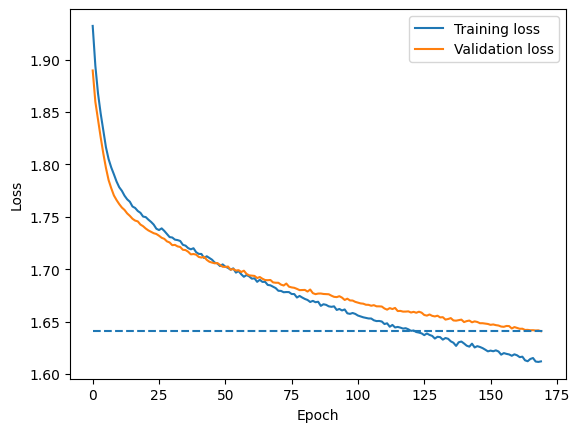

In [ ]:
model_shallow_cnn = StandardCNN(
    M=2,
    N=1,
    conv_channels=[32, 64],
    fc_dims=[512],
    krenel_sizes=[3,5]
)
model_shallow_cnn.to(device)
model_standard_cnn_losses, model_standard_cnn_val_losses = train(model_shallow_cnn, x_train, y_train, epochs=170, lr=1e-5, weight_decay=1e-7, get_losses=True)
err, acc = eval(model_shallow_cnn, x_test, y_test)
show_losses(model_standard_cnn_losses, model_standard_cnn_val_losses)

In [ ]:
torch.save(model_deeper_cnn.state_dict(), f"model_deeper_cnn_weights_{acc*100:.0f}acc.pth")

In [88]:
model_deep_cnn = StandardCNN(
    M=4,
    N=2,
    conv_channels=[64, 128,512,512],
    fc_dims=[256, 512],
    krenel_sizes=[3,5,3,3]
)
model_deep_cnn.to(device)
model_deep_cnn.load_state_dict(torch.load("K:\ERIK\Faks\Seminar II\Modeli\Deep CNN\model_deep_cnn_weights_59acc.pth", map_location=device))
err, acc = eval(model_deep_cnn, x_test, y_test)

Starting evaluation...
Model accuracy = 59.07%
Model error = 1.57


Starting training...
	Epoch[1/100]
	Epoch[11/100]
	Epoch[21/100]
	Epoch[31/100]
	Epoch[41/100]
	Epoch[51/100]
	Epoch[61/100]
	Epoch[71/100]
	Epoch[81/100]
	Epoch[91/100]
Training lasted 1213.926688194275 seconds.
Starting evaluation...
Model accuracy = 59.07%
Model error = 1.57


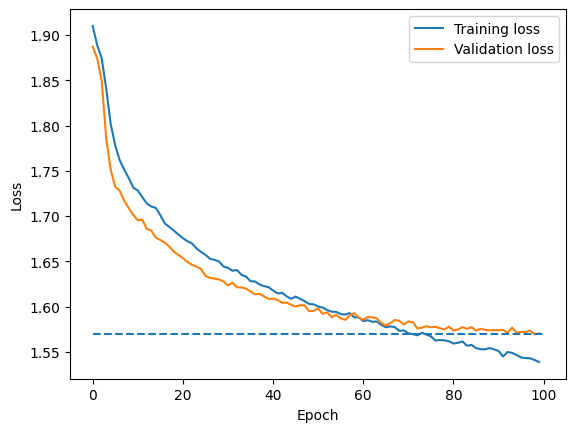

In [ ]:
model_deep_cnn = StandardCNN(
    M=4,
    N=2,
    conv_channels=[64, 128,512,512],
    fc_dims=[256, 512],
    krenel_sizes=[3,5,3,3]
)
model_deep_cnn.to(device)
model_deep_cnn_losses, model_deep_cnn_val_losses = train(model_deep_cnn, x_train, y_train, epochs=100, lr=0.0001, weight_decay=1e-7, get_losses=True)
err, acc = eval(model_deep_cnn, x_test, y_test)
show_losses(model_deep_cnn_losses, model_deep_cnn_val_losses)

Starting training...
	Epoch[1/100]
	Epoch[11/100]
	Epoch[21/100]
	Epoch[31/100]
	Epoch[41/100]
	Epoch[51/100]
	Epoch[61/100]
	Epoch[71/100]
	Epoch[81/100]
	Epoch[91/100]
Training lasted 1023.381965637207 seconds.
Starting evaluation...
Model accuracy = 61.76%
Model error = 1.08


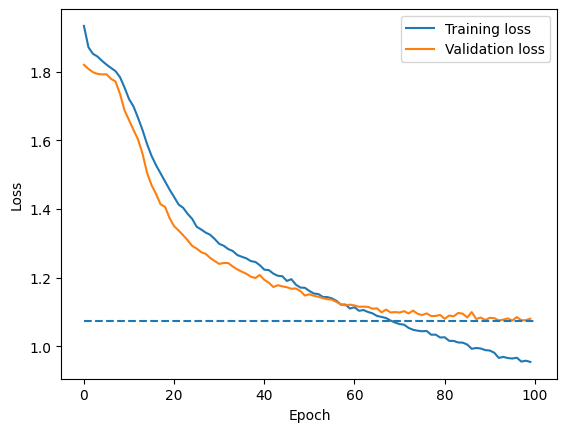

In [ ]:
model_deeper_cnn = StandardCNN(
    M=5,
    N=2,
    conv_channels=[64, 128,256,512,512],
    fc_dims=[256, 512],
    krenel_sizes=[3,5,3,3,3]
)
model_deeper_cnn.to(device)
model_deeper_cnn_losses, model_deeper_cnn_val_losses = train(model_deeper_cnn, x_train, y_train, epochs=100, lr=0.0001, weight_decay=1e-7, get_losses=True)
err, acc = eval(model_deeper_cnn, x_test, y_test)
show_losses(model_deeper_cnn_losses, model_deeper_cnn_val_losses)

In [31]:
model_deeper_cnn = StandardCNN(
    M=5,
    N=2,
    conv_channels=[64, 128,256,512,512],
    fc_dims=[256, 512],
    krenel_sizes=[3,5,3,3,3]
)
model_deeper_cnn.to(device)
model_deeper_cnn.load_state_dict(torch.load("K:\ERIK\Faks\Seminar II\Modeli\Deeper CNN\model_deeper_cnn_weights_59acc.pth", map_location=device))
err, acc = eval(model_deeper_cnn, x_test, y_test)

Starting evaluation...
Model accuracy = 61.76%
Model error = 1.59


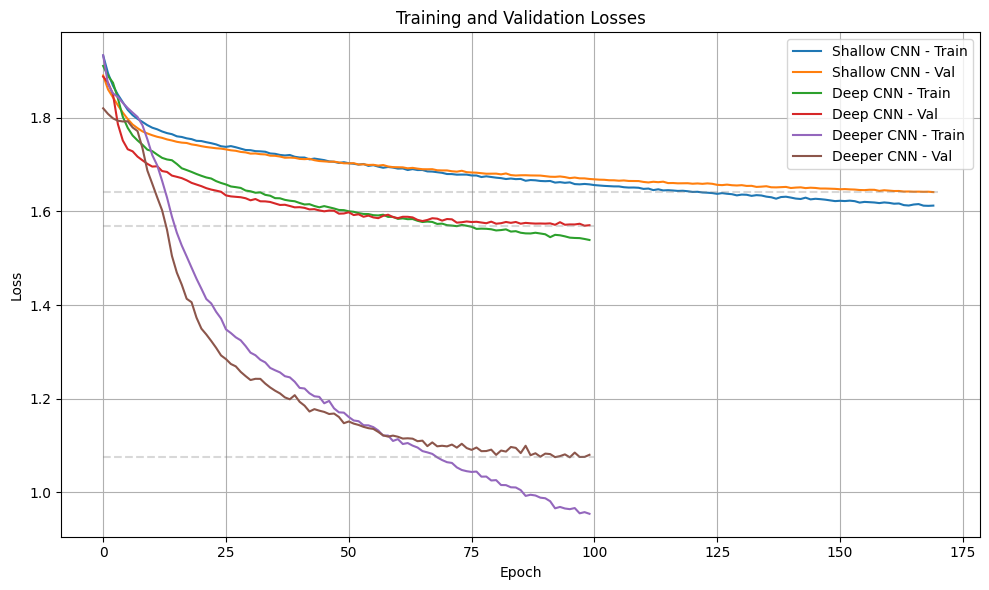

In [ ]:
show_multiple_losses(
    all_losses=[model_standard_cnn_losses, model_deep_cnn_losses, model_deeper_cnn_losses],
    all_val_losses=[model_standard_cnn_val_losses, model_deep_cnn_val_losses, model_deeper_cnn_val_losses],
    labels=["Shallow CNN", "Deep CNN", "Deeper CNN"]
)

In [84]:
model_deepest_cnn = StandardCNN(
    M=5,
    N=3,
    conv_channels=[64, 128,256,512,512],
    fc_dims=[128,256, 512],
    krenel_sizes=[3,5,5,3,3]
)
model_deepest_cnn.to(device)
model_deepest_cnn_losses, model_deepest_cnn_val_losses = train(model_deepest_cnn, x_train, y_train, epochs=100, lr=0.0001, weight_decay=1e-7, get_losses=True)
err, acc = eval(model_deepest_cnn, x_test, y_test)
show_losses(model_deepest_cnn_losses, model_deepest_cnn_val_losses)

Starting training...
	Epoch[1/100]
	Epoch[11/100]
	Epoch[21/100]
	Epoch[31/100]
	Epoch[41/100]
	Epoch[51/100]
	Epoch[61/100]
	Epoch[71/100]
	Epoch[81/100]
	Epoch[91/100]
Training lasted 1093.728068113327 seconds.
Starting evaluation...
Model accuracy = 55.65%
Model error = 1.60


NameError: name 'show_losses' is not defined

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

def cross_validate(model_fn, x_data, y_data, epochs, lr, weight_decay, folds=5, batch_size=128):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(x_data)), torch.from_numpy(np.array(y_data)))

    val_losses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(x_data)):
        #print(f"\nFold {fold+1}/{folds}")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model = model_fn()  # Svaki fold novi model!
        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in range(epochs):
            model.train()
            for X, y_true in train_loader:
                X = X.to(device)
                y_true = y_true.to(device)

                y_pred = model(X)
                loss = F.cross_entropy(y_pred, y_true.long())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Validation phase
        model.eval()
        val_loss_sum = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                val_pred = model(X_val)
                loss = F.cross_entropy(val_pred, y_val.long())
                val_loss_sum += loss.item() * X_val.size(0)

        avg_val_loss = val_loss_sum / len(val_subset)
        val_losses.append(avg_val_loss)

        print(f"Validation Loss for fold {fold+1}: {avg_val_loss:.4f}")

    avg_cv_loss = np.mean(val_losses)
    print(f"\nAverage Cross-Validation Loss: {avg_cv_loss:.4f}")

    return avg_cv_loss

def grid_search(model_fn, x_data, y_data, lr_list, wd_list, epochs=10, folds=5, batch_size=128):
    best_params = None
    best_val_loss = float('inf')

    for lr in lr_list:
        for weight_decay in wd_list:
            print(f"Testing lr={lr}, weight_decay={weight_decay}")

            avg_val_loss = cross_validate(
                model_fn=model_fn,
                x_data=x_data,
                y_data=y_data,
                epochs=epochs,
                lr=lr,
                weight_decay=weight_decay,
                folds=folds,
                batch_size=batch_size
            )

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_params = {'lr': lr, 'weight_decay': weight_decay}

    print("\nBest hyperparameters found:")
    print(f"lr = {best_params['lr']}, weight_decay = {best_params['weight_decay']}")
    print(f"With avg validation loss = {best_val_loss:.4f}")

    return best_params

In [ ]:
def model_shallow_cnn_gen():
    model_shallow_cnn = StandardCNN(
        M=2,
        N=1,
        conv_channels=[32, 64],
        fc_dims=[512],
        krenel_sizes=[3,3]
    )
    return model

def model_standard_cnn_gen():
    model_standard_cnn = StandardCNN(
        M=4,
        N=2,
        conv_channels=[64, 128,512,512],
        fc_dims=[256, 512],
        krenel_sizes=[3,5,3,3]
    )
    return model

lr_list = [1e-3, 1e-4, 1e-5]
wd_list = [1e-6, 1e-7, 1e-8, 1e-9]

# Pokreni grid search:
best_params = grid_search(model_shallow_cnn_gen, x_train, y_train, lr_list, wd_list, epochs=10)

Testing lr=0.001, weight_decay=1e-06
Validation Loss for fold 1: 1.6269
Validation Loss for fold 2: 1.5892
Validation Loss for fold 3: 1.5719
Validation Loss for fold 4: 1.6543
Validation Loss for fold 5: 1.5338

Average Cross-Validation Loss: 1.5952
Testing lr=0.001, weight_decay=1e-07
Validation Loss for fold 1: 1.5537
Validation Loss for fold 2: 1.5514
Validation Loss for fold 3: 1.6000
Validation Loss for fold 4: 1.6008
Validation Loss for fold 5: 1.5690

Average Cross-Validation Loss: 1.5750
Testing lr=0.001, weight_decay=1e-08
Validation Loss for fold 1: 1.5967
Validation Loss for fold 2: 1.6087
Validation Loss for fold 3: 1.5460
Validation Loss for fold 4: 1.6587
Validation Loss for fold 5: 1.6128

Average Cross-Validation Loss: 1.6046
Testing lr=0.001, weight_decay=1e-09
Validation Loss for fold 1: 1.5668
Validation Loss for fold 2: 1.5029
Validation Loss for fold 3: 1.5258
Validation Loss for fold 4: 1.5410
Validation Loss for fold 5: 1.5599

Average Cross-Validation Loss: 1.5

In [ ]:
from sklearn.metrics import accuracy_score

def compute_per_class_accuracy(model, x_data, y_data, emotion_indexes, device):
    model.eval()
    class_correct = {i: 0 for i in range(len(emotion_indexes))}
    class_total = {i: 0 for i in range(len(emotion_indexes))}

    with torch.no_grad():
        for i in range(len(x_data)):
            x = torch.from_numpy(x_data[i]).unsqueeze(0).to(device)  # (1, 1, 48, 48)
            y_true = y_data[i]
            y_pred = model(x).argmax(dim=1).item()

            class_total[y_true] += 1
            if y_pred == y_true:
                class_correct[y_true] += 1

    accuracies = {}
    inv_emotion_indexes = {v: k for k, v in emotion_indexes.items()}
    for idx in class_total:
        emotion = inv_emotion_indexes[idx]
        if class_total[idx] > 0:
            acc = 100 * class_correct[idx] / class_total[idx]
        else:
            acc = 0
        accuracies[emotion] = acc

    return accuracies

acc_shallow = compute_per_class_accuracy(model_shallow_cnn, x_test, y_test, emotion_indexes, device)
acc_deep = compute_per_class_accuracy(model_deep_cnn, x_test, y_test, emotion_indexes, device)
acc_deeper = compute_per_class_accuracy(model_deeper_cnn, x_test, y_test, emotion_indexes, device)

# Ispis u tablici
print(f"{'Expression':<10} {'Shallow':>10} {'Deep':>10}")
for emotion in emotion_indexes:
    s = acc_shallow.get(emotion, 0)
    d = acc_deep.get(emotion, 0)
    e = acc_deeper.get(emotion, 0)
    print(f"{emotion:<10} {s:>9.1f}% {d:>9.1f}% {e:>9.1f}%")

Expression    Shallow       Deep
angry           45.9%      49.7%
disgust          0.0%      39.2%
fear            24.2%      23.8%
happy           84.2%      86.8%
sad             49.6%      51.0%
surprise        73.3%      81.4%
neutral         65.8%      65.1%


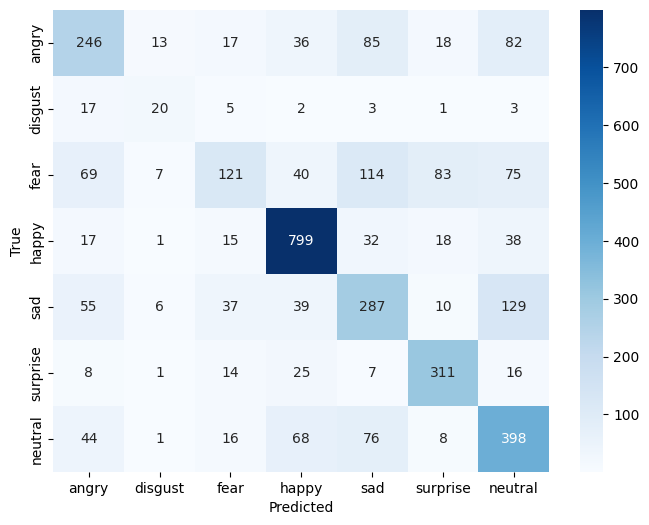

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
emotion_labels = list(emotion_indexes.keys())

def plot_confusion_matrix(model, x_data, y_data, emotion_labels, normalize=False):
    model.eval()
    with torch.no_grad():
        x_tensor = torch.from_numpy(x_data).to(device)
        y_true = torch.tensor(y_data).to(device)

        y_pred_logits = model(x_tensor)
        y_pred = torch.argmax(y_pred_logits, dim=1)

    cm = confusion_matrix(y_true.cpu(), y_pred.cpu())

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d",
                cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
plot_confusion_matrix(model_deeper_cnn, x_test, y_test, emotion_labels)

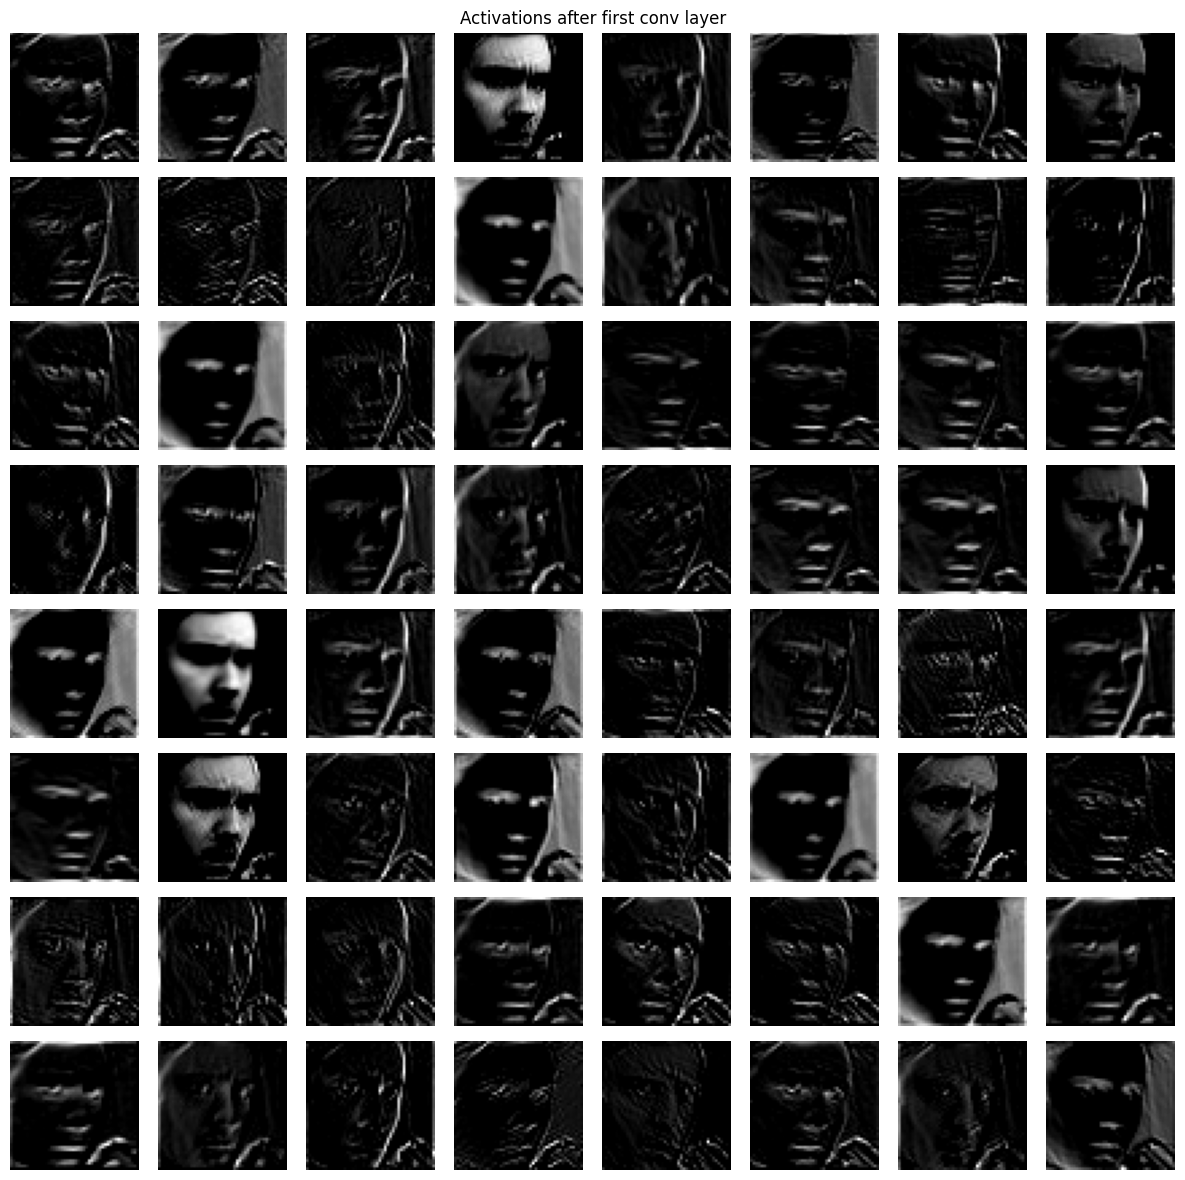

In [75]:
def visualize_first_layer_activations(model, input_image, device='cpu'):
    model.eval()
    model.to(device)
 
    if isinstance(input_image, np.ndarray):
        input_image = torch.from_numpy(input_image)
    if input_image.ndim == 2:  # (H, W)
        input_image = input_image.unsqueeze(0).unsqueeze(0)
    elif input_image.ndim == 3:  # (1, H, W)
        input_image = input_image.unsqueeze(0)
    input_image = input_image.to(torch.float32).to(device)

    with torch.no_grad():
        # Prođi samo prvi konvolucijski blok
        x = input_image
        x = model.convs[0](x)
        x = model.bns_conv[0](x)
        x = torch.relu(x)
        activations = x.squeeze(0).cpu().numpy()  # (num_filters, H, W)

    # Vizualizacija
    num_filters = activations.shape[0]
    cols = int(np.sqrt(num_filters))
    rows = int(np.ceil(num_filters / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols, 1.5*rows))
    for i in range(rows * cols):
        if i < num_filters:
            act_map = activations[i]
            act_map = (act_map - act_map.min()) / (act_map.max() - act_map.min() + 1e-5)
            axes[i // cols, i % cols].imshow(act_map, cmap='gray')
        axes[i // cols, i % cols].axis('off')
    plt.suptitle("Activations after first conv layer")
    plt.tight_layout()
    plt.show()
 
img = x_train[0]
visualize_first_layer_activations(model_deeper_cnn, img, device=device)

**Convert the model to ONNX**

In [1]:
import torch.onnx
def convert(model, model_name):
  model.eval()
  dummy_input = torch.randn(1,48, 48)
  # torch.onnx.export(model, dummy_input, f"{model_name}.onnx",
  #                   input_names=['input'], output_names=['output'],
  #                   dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})
  torch.onnx.export(
    model,
    dummy_input,
    f"{model_name}.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=11,          
    do_constant_folding=True 
)

In [ ]:
model_deeper_cnn = StandardCNN(
    M=5,
    N=2,
    conv_channels=[64, 128,256,512,512],
    fc_dims=[256, 512],
    krenel_sizes=[3,5,3,3,3]
)
model_deeper_cnn.to(device)
model_deeper_cnn.load_state_dict(torch.load("C:\Users\eriki\OneDrive\Dokumenti\Faks\Diplomski\Semestar II\Seminar II\Modeli\Deeper CNN\model_deeper_cnn_weights_62acc.pth", map_location=device))
err, acc = eval(model_deeper_cnn, x_test, y_test)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (Temp/ipykernel_21180/3616450657.py, line 9)

In [ ]:
convert(model_standard_cnn, "model_standard_cnn")

In [ ]:
convert(model_cnn, "model_cnn")

In [1]:
%pip install onnx

  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
scipy 1.7.1 requires numpy<1.23.0,>=1.16.5, but you have numpy 2.0.2 which is incompatible.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 2.0.2 which is incompatible.
